<a href="https://colab.research.google.com/github/jiku100/2020-2-machine-running-proejct/blob/master/assignment10/%EC%8B%A0%EC%84%9D%EA%B2%BD_assignment_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classification for Multiple Categories using Pytorch for best accuracy**



# 1. Import library
<hr>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("다음 기기로 학습합니다:", device)

다음 기기로 학습합니다: cuda


# 2. Preprocessing Data
<hr>

In [3]:
transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomRotation(20),
        transforms.Normalize((0.1307,),(0.3081,))                    # 이미지를 텐서로 변형합니다.
])

transform_test = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,),(0.3081,))            
])

In [4]:
data_path = './MNIST'

data_test   = datasets.MNIST(root = data_path, train= True, download=True, transform= transform_test)
data_train  = datasets.MNIST(root = data_path, train= False, download=True, transform= transform_train)

type of one image <class 'torch.Tensor'>
size of one image :  torch.Size([1, 28, 28])
type of label :  <class 'int'>
label :  7
255


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


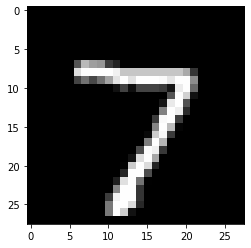

In [5]:
one_image, label = data_train[0]
print("type of one image", type(one_image))
print("size of one image : ", one_image.shape)
plt.imshow(one_image.squeeze().numpy(), cmap='gray')
print("type of label : ", type(label))
print("label : ", label)
print(np.max(data_train.train_data[0].view(-1).numpy()))

In [6]:
learning_rate = 0.0015
training_epochs = 600
batch_size = 32
drop_prob = 0.4

In [7]:
train_loader = DataLoader(dataset = data_train, batch_size = batch_size, num_workers = 2, shuffle = True) ## batch size 32 짜리 train loader 생성
test_loader = DataLoader(dataset = data_test, batch_size = batch_size, num_workers = 2, shuffle = True) ## batch size 32 짜리 test loader 생성

# 3. Define Model
<hr>

In [8]:
class classification(nn.Module):
    def __init__(self):
        super(classification, self).__init__()
        
        # construct layers for a neural network
        self.classifier1 = nn.Sequential(
            nn.Linear(in_features=28*28, out_features=400),
            nn.BatchNorm1d(400),
            nn.ReLU(),
            nn.Dropout(p=drop_prob)
        ) 
        self.classifier2 = nn.Sequential(
            nn.Linear(in_features=400, out_features=100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Dropout(p=drop_prob)
        ) 
        self.classifier3 = nn.Sequential(
            nn.Linear(in_features=100, out_features=10),
        ) 

        # for m in self.modules():
        #   if isinstance(m, nn.Linear):
        #     init.kaiming_normal_(m.weight.data) # Kaming He Initialization
        #     m.bias.data.fill_(0)                # 편차를 0으로 초기화 

    def forward(self, inputs):                 # [batchSize, 1, 28, 28]
        x = inputs.view(inputs.size(0), -1)    # [batchSize, 28*28]
        x = self.classifier1(x)                # [batchSize, 20*20]
        x = self.classifier2(x)                # [batchSize, 10*10]
        out = self.classifier3(x)              # [batchSize, 10]
        
        return out



In [9]:
model = classification().to(device)

In [10]:
criterion = nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, 100, gamma=0.1, last_epoch=-1)

# 4. Training
<hr>

In [11]:
total_batch= len(train_loader)

In [12]:
print(total_batch)

313


In [13]:
def accuracy(log_pred, y_true):
    y_pred = torch.argmax(log_pred, dim=1)
    return (y_pred == y_true).to(torch.float).mean()

In [14]:
def training(model, loss, optim, training_epochs, train_loader, test_loader):
  L_iters_train = []
  accuracy_train = []
  L_iters_test = []
  accuracy_test = []
  for epoch in range(training_epochs):
    total_cost_train = 0
    total_cost_test = 0
    total_acc_train = 0
    total_acc_test = 0
    model.train()
    for X, Y in train_loader:
      X = X.to(device)
      Y = Y.to(device)

      optim.zero_grad()
      train_pred = model(X)
      cost = loss(train_pred, Y)
      cost.backward()
      optim.step()

      total_cost_train += cost
      total_acc_train += accuracy(train_pred, Y)
      
    avg_cost_train = total_cost_train / len(train_loader)
    avg_acc_train = total_acc_train / len(train_loader)

    L_iters_train.append(avg_cost_train)
    accuracy_train.append(avg_acc_train)
    model.eval()
    with torch.no_grad():
      for X_test, Y_test in test_loader:
        X_test = X_test.to(device)
        Y_test = Y_test.to(device)
        test_pred = model(X_test)
        cost_test = loss(test_pred, Y_test)
        total_cost_test += cost_test
        total_acc_test += accuracy(test_pred, Y_test)
      avg_cost_test = total_cost_test / len(test_loader)
      avg_acc_test = total_acc_test / len(test_loader)
    
      accuracy_test.append(avg_acc_test)
      L_iters_test.append(avg_cost_test)

    print("Epoch: %02d Training Loss: %.9f Testing Loss: %.9f  Training Acc: %.9f Testing Acc: %.9f" %((epoch + 1),avg_cost_train, avg_cost_test, avg_acc_train, avg_acc_test))
  return L_iters_train, accuracy_train, L_iters_test, accuracy_test

In [15]:
L_train, A_train, L_test, A_test = training(model, criterion, optimizer, training_epochs, train_loader, test_loader)

Epoch: 01 Training Loss: 0.674379110 Testing Loss: 0.282798052  Training Acc: 0.810702860 Testing Acc: 0.915950000
Epoch: 02 Training Loss: 0.391580403 Testing Loss: 0.211681306  Training Acc: 0.877196491 Testing Acc: 0.938066661
Epoch: 03 Training Loss: 0.337955147 Testing Loss: 0.182519987  Training Acc: 0.895367384 Testing Acc: 0.945100009
Epoch: 04 Training Loss: 0.295732945 Testing Loss: 0.161198899  Training Acc: 0.905551076 Testing Acc: 0.951483369
Epoch: 05 Training Loss: 0.273140341 Testing Loss: 0.158408776  Training Acc: 0.914636552 Testing Acc: 0.952000022
Epoch: 06 Training Loss: 0.247542411 Testing Loss: 0.137817040  Training Acc: 0.922224402 Testing Acc: 0.958100021
Epoch: 07 Training Loss: 0.237068146 Testing Loss: 0.137817860  Training Acc: 0.925818682 Testing Acc: 0.958633363
Epoch: 08 Training Loss: 0.231049329 Testing Loss: 0.131560475  Training Acc: 0.930311501 Testing Acc: 0.960666656
Epoch: 09 Training Loss: 0.215406030 Testing Loss: 0.128056869  Training Acc: 0.

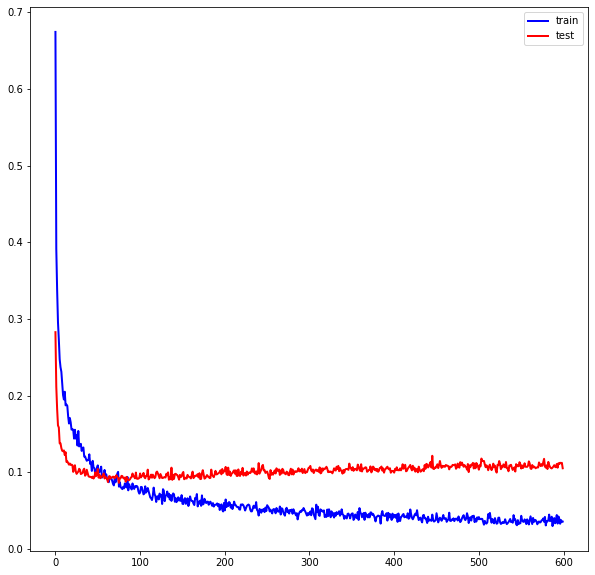

In [16]:
plt.figure(figsize = (10,10))
plt.plot(L_train, linewidth = 2, c='b', label = "train")
plt.plot(L_test, linewidth = 2, c='r', label = "test")
plt.legend()
plt.show()

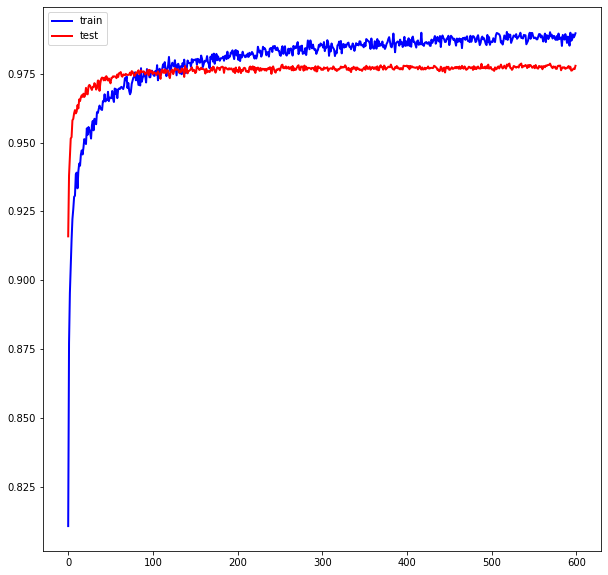

In [17]:
plt.figure(figsize = (10,10))
plt.plot(A_train, linewidth = 2, c='b', label = "train")
plt.plot(A_test, linewidth = 2, c='r', label = "test")
plt.legend()
plt.show()

In [18]:
print("training loss    %.2f" %(L_train[-1]))
print("testing loss     %.2f" %(L_test[-1]))
print("training acc    %.2f" %(A_train[-1]))
print("testing acc     %.2f" %(A_test[-1]))

training loss    0.04
testing loss     0.11
training acc    0.99
testing acc     0.98


# 5. Output
<hr>

## 1. Plot the training and testing losses over epochs

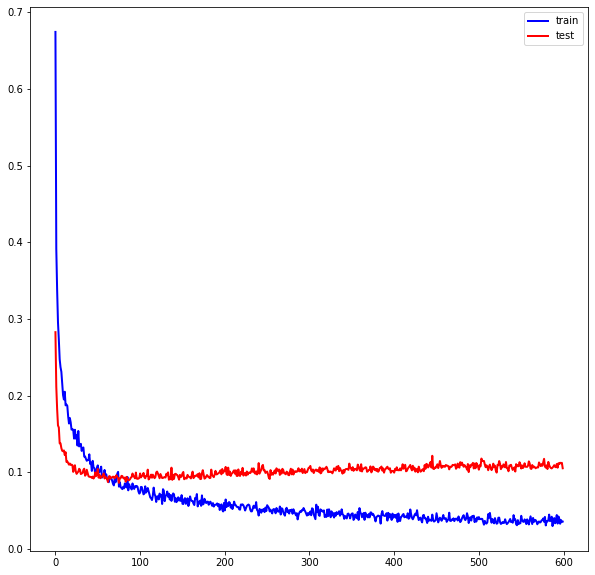

In [19]:
plt.figure(figsize = (10,10))
plt.plot(L_train, linewidth = 2, c='b', label = "train")
plt.plot(L_test, linewidth = 2, c='r', label = "test")
plt.legend()
plt.show()

## 2. Plot the training and testing accuracies over epochs

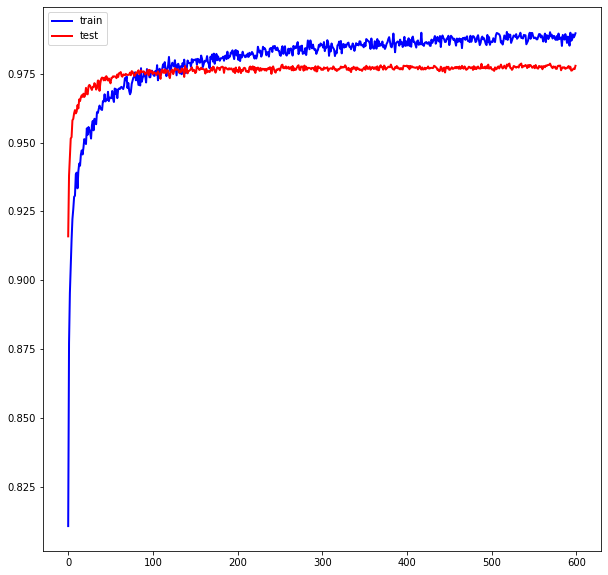

In [20]:
plt.figure(figsize = (10,10))
plt.plot(A_train, linewidth = 2, c='b', label = "train")
plt.plot(A_test, linewidth = 2, c='r', label = "test")
plt.legend()
plt.show()

## 3.  Print the final training and testing losses at convergence 

In [21]:
print("loss")
print("train    %.2f" %(L_train[-1]))
print("test     %.2f" %(L_test[-1]))

loss
train    0.04
test     0.11


## 4. Print the final training and testing accuracies at convergence

In [23]:
print("Accuracy")
print("train    %.6f, %.2f" %(A_train[-1], A_train[-1]))
print("test     %.6f, %.2f" %(A_test[-1], A_test[-1]))

Accuracy
train    0.989716, 0.99
test     0.977900, 0.98
